# Detecting Viral and Bacterial Pneumonia from Chest Xrays

### With Colaboratory, Drive, Transfer Learning, and Data Augmentation

#### Summary
Pneumonia is a lung infection that can be caused by a virus or bacteria growing in the lungs. A common way to screen for pneumonia is to analyze chest x-rays for signs of the infection. On an x-ray, pneumonia will present itself as little white dots in the lungs called infiltrates. This distinct visual feature of pneumonia makes it a candidate for detection by convolutional neural networks. If a visual difference exists between normal lungs and infected lungs, then it should be detectable by a convolutional neural network.   <br>

#### Methods
This notebook creates a three-class model that classifies x-rays as either normal, having bacterial pneumonia, or viral pneumonia. It is based on a Kaggle hosted dataset (https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia) and is designed to use free cloud computing resources from Google. Collaboratory is used for coding and computing, and Drive is used to host input data for the model. Presenting a free and generalized approach to this problem creates a foundation that can be applied to any deep learning problem with the modification of a few lines of code. <br>

To solve the problem, this notebook will employ data augmentation and transfer learning. These two techniques are known to improve classification scores on small datasets. 

To begin, load the libraries that will be required for the project.

In [ ]:
import tensorflow as tf
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image # Library to help view images
from IPython.display import display # Library to help view images

from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import backend
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Concatenate, Dense, Dropout, Flatten, Activation, BatchNormalization # We add the Concatentate function
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Library for data augmentation
from tensorflow.keras.applications import  Xception
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image

import os, shutil # Library for navigating files
from google.colab import drive # Library to mount google drives
np.random.seed(42)

# Importing Training and Test Images from Google Drive

The original dataset contains three folders that separate images into training, validation, and test sets. These folders contain sub directories that further separate images into normal and pneumonia image classes. The original validation folder only contains 8 images of each type, which is not enough to perform validation during training. Rather than use these 8 images for validation, they are included in the training folders, and a validation split will be implemented later using Keras' ImageDataGenerator. 

Keras will automatically assign class labels to the data using the directory structure created in the the drive. To support a 3 class model, images of viral and bacterial pneumonia were separated into separate files in Google Drive which sets up the model for prediction of bacterial, normal, and viral classes. 

Training and test data can be connected to Collaboratory from Drive with the code shown below.

1. Mount a Google Drive.
2. Define the base directory location.
3. Define training and test directories.
4. Optional - specify class directory structure. Used for step 5 and image visualization in next section.
5. Optional - print total number of pictures in each directory.

Inspired by Regis University MSDS Deep Learning Curriculum

In [ ]:
#step 1, mount google drive (will require permission to login to your google account)
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#step 2, specify the base directory where images are located.  You need to save your data here.
base_dir = '/content/gdrive/My Drive/chest_xray/'

In [ ]:
#step 3, specify the training, validation, and test directories.  
#no validation directory exists for this set, validation split will be performed by the image generator below
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

In [ ]:
#step 4, specify class directory structure
train_normal_dir = os.path.join(train_dir, 'NORMAL')
train_bacterial_dir = os.path.join(train_dir, 'BACTERIAL_PNEUMONIA')
train_virus_dir = os.path.join(train_dir, 'VIRIAL_PNEUMONIA')

test_normal_dir = os.path.join(test_dir, 'NORMAL')
test_bacterial_dir = os.path.join(test_dir, 'BACTERIAL_PNEUMONIA')
test_virus_dir = os.path.join(test_dir, 'VIRIAL_PNEUMONIA')

In [ ]:
#step 5, print total number of files in each directory
print(len(os.listdir(train_normal_dir)))
print(len(os.listdir(train_bacterial_dir)))
print(len(os.listdir(train_virus_dir)))
print(len(os.listdir(test_normal_dir)))
print(len(os.listdir(test_bacterial_dir)))
print(len(os.listdir(test_virus_dir)))

1349
2538
1346
234
242
149


# Correct for Class Imbalance

The class distribution of the dataset is not evenly spread among all of the possible classes. There are far more bacterial images than there are normal and viral. This class imbalance can skew the results of the model, which may favor predicting for the largest class in the dataset. To accommodate for class imbalance, the class weights can be calculated and passed into the model. This causes the model to pay more attention to examples from classes with fewer examples in the model.

Inspired by Tensorflow documentation. https://www.tensorflow.org/tutorials/structured_data/imbalanced_data


In [ ]:
# calculate class weight for each class
# important note, keras assigns classes in alphanumberic order, so bacteria = 0, normal = 1, viral =2
class_0_weight = (1 / len(os.listdir(train_bacterial_dir))) * (len(train_normal_dir)+len(os.listdir(train_bacterial_dir))+len(os.listdir(train_virus_dir)) / 3.0)
class_1_weight = (1 / len(os.listdir(train_normal_dir))) * (len(train_normal_dir)+len(os.listdir(train_bacterial_dir))+len(os.listdir(train_virus_dir)) / 3.0)
class_2_weight = (1 / len(os.listdir(train_virus_dir))) * (len(train_normal_dir)+len(os.listdir(train_bacterial_dir))+len(os.listdir(train_virus_dir)) / 3.0)

class_weights = {0: class_0_weight, 1: class_1_weight, 2: class_2_weight}

print('Weight for class 0: {:.2f}'.format(class_0_weight))
print('Weight for class 1: {:.2f}'.format(class_1_weight))
print('Weight for class 2: {:.2f}'.format(class_2_weight))

Weight for class 0: 1.20
Weight for class 1: 2.25
Weight for class 2: 2.25


# Visualize Images from Directory

The following code visualizes unmodified images from each class in the training directory.

1. Create directory address for random image from each directory.
2. Display images.

Inspired by Karnika Kapoor https://www.kaggle.com/code/karnikakapoor/pneumonia-diagnosis-convnet-model/notebook


Sample a random image from each directory
/content/gdrive/My Drive/chest_xray/train/NORMAL/IM-0472-0001.jpeg


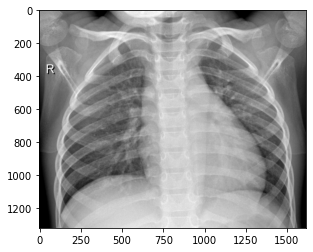

/content/gdrive/My Drive/chest_xray/train/BACTERIAL_PNEUMONIA/person718_bacteria_2620.jpeg


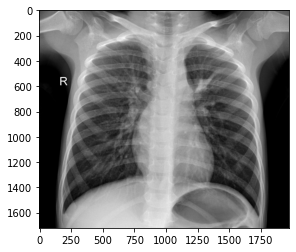

/content/gdrive/My Drive/chest_xray/train/VIRIAL_PNEUMONIA/person464_virus_956.jpeg


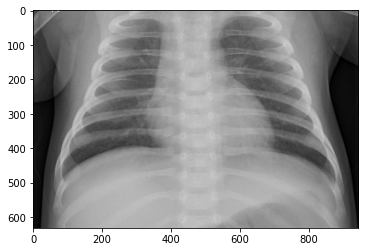

In [ ]:
#step 1, create directory address for random image
normal_address = train_normal_dir+'/'+random.choice(os.listdir(train_normal_dir))
bacterial_address = train_bacterial_dir+'/'+random.choice(os.listdir(train_bacterial_dir))
viral_address = train_virus_dir+'/'+random.choice(os.listdir(train_virus_dir))
display_set = [normal_address, bacterial_address, viral_address]

#step 2, display random images
print("Sample a random image from each directory")
for display in display_set: 
    print(display)
    img = image.load_img(display)
    plt.figure()
    plt.imshow(img)
    plt.show() 

# Define Augmentation and flow_from_directory Image Stream

The code below creates a stream of images from Google Drive for input into the model. The provided dataset only contains about 5000 images, this is considered a relatively small training dataset. This can inhibit a models ability to predict with high accuracy. To get around this bottleneck, data augmentation is applied to expand the size of the training dataset. A validation split is also arranged here to separate the data into training and validation sets.

1. Create augmentation image data generator. Items left commented for experimentation.
  - Rescale data
  - Apply augmentation settings
  - Specify validation split (required as there is no validation dataset in the directory)
2. Combine Image Data Generator and flow from directory to stream images from google drive to model.
  - Specify directory location
  - Define image size and batch size
  - Specify images as training or validation subsets (required to use validation split)
  - Do not apply augmentation to test data, a test specific generator is created that does not include augmentation settings.

Inspired by Regis University MSDS Deep Learning Curriculum

In [ ]:
#step 1, creata augmentation image data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
#    width_shift_range=0.2,
#    height_shift_range=0.2,
#    shear_range=0.2,
#    zoom_range=0.2,
    brightness_range=(0.9, 1.1),
    horizontal_flip=True,
#    vertical_flip=True,
    validation_split=0.2,
    fill_mode='nearest')

#step 2, combine image data generator and flow_from_directory to setup image stream
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=20,
    class_mode='categorical',
    subset='training')

validataion_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=20,
    class_mode='categorical',
    subset='validation')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=20,
    class_mode='categorical')


Found 4187 images belonging to 3 classes.
Found 1045 images belonging to 3 classes.
Found 624 images belonging to 3 classes.


# Visualize Augmentation and Data from flow_from_directory

The next block of code will visualize the results of the data augmentation and flow_from_directory steps taken above. The 
images have been rescaled and now have had their labels one_hot encoded to prepare them for implementation in the deep learning model.

1. Use next() to generate training images and their labels from training generator.
2. Define plotImages() function to plot sample images and labels.
3. Plot images created by the training generator.

Inspired by Tensorflow's Classification Tutorial https://www.tensorflow.org/tutorials/images/classification


In [ ]:
#step 1, pull out training images and labels from generator
sample_training_images, labels = next(train_generator)

In [ ]:
#step 2, define plotimages function
def plotImages(images_arr,title):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax, titl in zip( images_arr, axes, title):
        ax.set_title(titl)
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


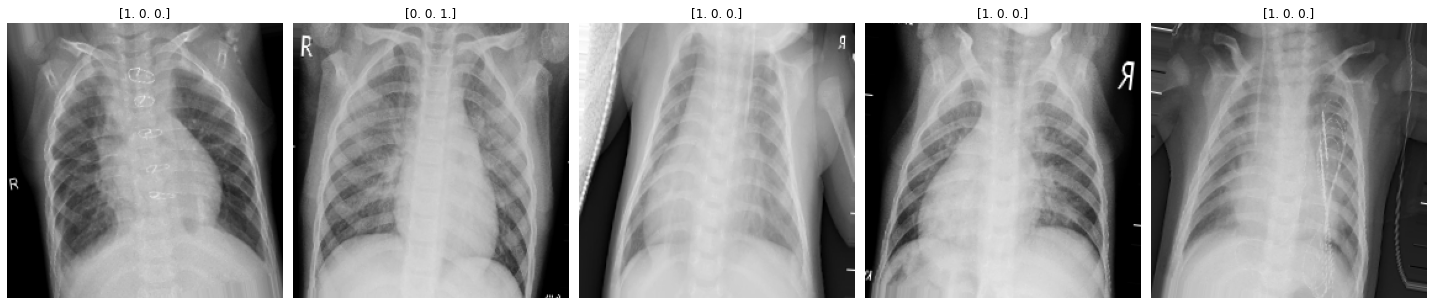

In [ ]:
#step 3, plot images
plotImages(sample_training_images[:5], labels[:5])

# Creating a Transfer Learning Model

A leading approach for image classification problems is to apply a technique called transfer learning. Transfer learning takes an existing high-performance model and applies its parameters to a new problem. Transfer learning saves computational resources and usually results in better performance than can be achieved from a unique hand-built model.

The Xception model will be used for this transfer learning approach. Xception was inspired by the InceptionV3 architecture, but places a more extreme focus on mapping cross channel correlations with depth wise convolutions. It has been shown to outperform InceptionV3 on classification tasks it has not been trained on. 

1. Import Xception model without classifier portion of network
2. Select frozen layers.
  - The last 6 layers, forming the final convolutional block, will be left unfrozen so that they can be trained for pneumonia specific feature importance.
3. Create classifier block to predict for 3 classes.
4. Compile and fit model.
5. Generate graphs on training performance.
6. Test model on never before seen data.

Inspired by Regis University MSDS Deep Learning Curriculum

In [ ]:
#step 1, import xception model without classifier portion
backend.clear_session()
xception_base = Xception (weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))

#step 2, select frozen layers
for layer in xception_base.layers[:-6]:
  layer.trainable = False
for layer in xception_base.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f2b53d7b1d0> False
<keras.layers.convolutional.Conv2D object at 0x7f2a33d69750> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f2a33d32ed0> False
<keras.layers.core.activation.Activation object at 0x7f2a337e94d0> False
<keras.layers.convolutional.Conv2D object at 0x7f2a337c2e90> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f2a337c21d0> False
<keras.layers.core.activation.Activation object at 0x7f2a337fd310> False
<keras.layers.convolutional.SeparableConv2D object at 0x7f2a337b72d0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f2a337a7d50> False
<keras.layers.core.activation.Activation object at 0x7f2abd3eb790> False
<keras.layers.convolutional.SeparableConv2D object at 0x7f2b52513890> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f2a33828910> False
<keras.layers.convolutional.Co

Epoch 1/50
100/100 [==============================] - 81s 785ms/step - loss: 45.2301 - accuracy: 0.6195 - val_loss: 33.6545 - val_accuracy: 0.6760
Epoch 2/50
100/100 [==============================] - 76s 756ms/step - loss: 14.9807 - accuracy: 0.6625 - val_loss: 4.1294 - val_accuracy: 0.6140
Epoch 3/50
100/100 [==============================] - 74s 741ms/step - loss: 6.3057 - accuracy: 0.6623 - val_loss: 1.4152 - val_accuracy: 0.6730
Epoch 4/50
100/100 [==============================] - 74s 742ms/step - loss: 2.9762 - accuracy: 0.6930 - val_loss: 0.8085 - val_accuracy: 0.6500
Epoch 5/50
100/100 [==============================] - 74s 742ms/step - loss: 2.1426 - accuracy: 0.6860 - val_loss: 0.6219 - val_accuracy: 0.7260
Epoch 6/50
100/100 [==============================] - 74s 745ms/step - loss: 1.6615 - accuracy: 0.6935 - val_loss: 0.6845 - val_accuracy: 0.7180
Epoch 7/50
100/100 [==============================] - 74s 744ms/step - loss: 1.1716 - accuracy: 0.7330 - val_loss: 0.6373 - val

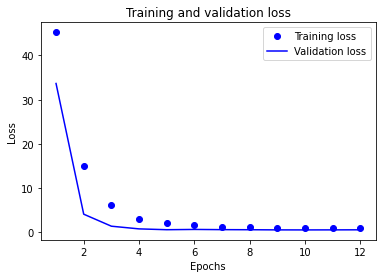

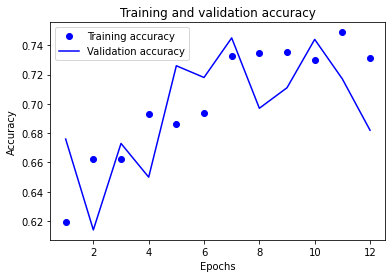

32/32 [==============================] - 8s 252ms/step - loss: 0.7411 - accuracy: 0.7853
test_acc: 0.7852563858032227


In [ ]:
#step 3, Create new classifier block to predict for 3 classes.
xception_train = models.Sequential()
xception_train.add(xception_base)
xception_train.add(layers.Flatten())
xception_train.add(layers.BatchNormalization())
xception_train.add(layers.Dense(1024, activation = 'relu'))
xception_train.add(layers.Dropout(0.5))
xception_train.add(layers.Dense(1024, activation = 'relu'))
xception_train.add(layers.Dropout(0.5))
xception_train.add(layers.Dense(3, activation = 'softmax'))

#step 4, compile and fit model
xception_train.compile(optimizer = optimizers.Adam(),
    loss = 'categorical_crossentropy',
    metrics = 'accuracy')

# Lr scheduler removed from model to improve performance, uncomment the code to try it.
#def scheduler(epoch, lr):
#  if epoch < 10:
#    return lr
#  else:
#    return lr * tf.math.exp(-0.1)

#defining learning rate callback for use in model.fit callbacks
#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

#fit model and save training history
history = xception_train.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=50,
    class_weight=class_weights, 
    validation_data=validataion_generator,
    validation_steps=50,
    verbose = 1,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights = True)])

#step 5, Generate graphs on training performance.
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(history_dict['accuracy']) + 1)

plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss_values, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, acc_values, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#step 6, test model on never before seen data
loss, acc = xception_train.evaluate(test_generator, steps = 32)
print('test_acc:', acc)


# Export or Load the Trained Model 

The following two lines of code can be used to export and import the model with saved weights from a Google Drive.


In [ ]:
#specify google drive location to export the trained model, include file name in h5 format
xception_train.save('/content/gdrive/My Drive/chest_xray/exception_penumonia.h5')

In [ ]:
# import trained model from google drive location
xception_train = keras.models.load_model('/content/gdrive/My Drive/chest_xray/exception_penumonia.h5')

# Training Discussion

The model achieves 78.5% accuracy when tested on an unseen stream of images. It takes 7 epochs to reach its best set of parameter weights. The training and validation curves produced by the model are somewhat linked. The linked curves suggest the model has not become overfit to its training data. 

Accuracy can be a misleading statistic in a classification model. While it does show how effective a model is, it does not offer any insight into how the model is predicting among the classes. The best way to get more insight into how a model is predicting is to generate a confusion matrix.

# Understanding the Model's Prediction with a Confusion Matrix.

 A confusion matrix shows the models predictions against the true labels in the dataset. It can reveal strengths and weaknesses in predicting certain classes and help differentiate the spread between true positive and true negative predictions in the model.

1. Import required libraries and define the plot_confusion_matrix function.
2. Create a flow_form_directory generator with shuffle=False.
3. Generate a list of labels and predictions.
4. Define class names (keras uses alphanumeric order).
5. Plot the confusion matrix.

inspired by deeplizard https://deeplizard.com/learn/video/km7pxKy4UHU


In [ ]:
#plot confusion matrix
# Step 1, Import Required Libraries
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

# define the confusion matrix function, from the sklearn documentation
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
#step 2, create a new, unshuffled flow_from_directory generator
confusion_test_datagen = ImageDataGenerator(rescale=1./255)

confusion_test_generator = confusion_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=20,
    class_mode='categorical',
    shuffle=False)

Found 624 images belonging to 3 classes.


In [ ]:
#step 3, create a list of labels and predictions
test_labels = confusion_test_generator.classes
y_prob = xception_train.predict(confusion_test_generator, steps = 32) 
preds = y_prob.argmax(axis=-1)

In [ ]:
#step 4, define class names and confusion matrix 
#Define class names
class_names = ['Bacterial','Normal','Viral']

#define confusion matrix object, set true labels and preds 
cm = confusion_matrix(test_labels, preds)

Confusion matrix, without normalization
[[214   7  21]
 [ 24 161  49]
 [ 29   4 115]]


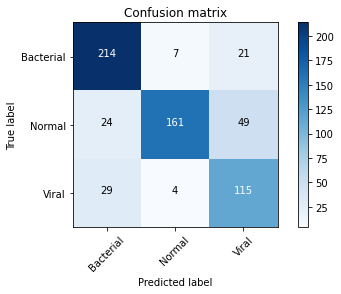

In [ ]:
#step 5, plot confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=class_names,
                      title='Confusion matrix')

plt.show()

# Confusion Matrix Discussion

The difference between predicted and true labels for each class is visualized in the confusion matrix above. The thick blue across the center of the matrix represents predictions that were true to their ground truth labels, 490 out of 624 x-rays were classified correctly, an accuracy rating of 78.5%.  

The Confusion Matrix gives insight into how the model predicted for each class. The model very rarely predicted someone with normal lungs had pneumonia, only identifying 11 patients with normal lungs as having pneumonia. However, the model often believed the patients had pneumonia when they were healthy. Incorrectly identifying pneumonia in 73 normal x-rays.

The confusion matrix also reveals that the model was able to discern between viral and bacterial pneumonia in the x-rays. While there was some mis categorization (19 out of 267 bacterial predictions ~ 7%, and 21 out of 185 viral predictions ~ 11%) the model was able to detect unique features for each type of pneumonia and differentiate between those two types of pneumonia in the test.

In addition to plotting a confusion matrix, visualizing the model's incorrect predictions can be helpful for understanding why it predicted classes for certain images.

# Show Images with Wrong Predictions

Visualizing which predictions are wrong can give insight into the errors made by the classifier. It can be used to illustrate weak areas and offer suggestions for improvements in the training data.

1. Define a new flow_from_directory generator that produces a sample of test files. 
2. Call next function on generator to return pictures and true classes from the generator
3. Use argmax function on y_prob (reused from confusion prediction) and true_class to reduce labels and predictions to a single number.
4. Isolate pictures where label is not equal to the prediction in a new list.
5. Use image show function to print out all mislabeled test images.

Adapted from: 
Abdulkader Helwan
https://www.codeproject.com/Articles/5297329/Running-AI-Fashion-Classification-on-Real-Data

In [ ]:
# step 1, create special image generator to produce sample of images for test
# resuses confusion test datagen ImageDataGenerator(w/rescaling)
misclassified_generator = confusion_test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=624,
    class_mode='categorical',
    shuffle=False)

Found 624 images belonging to 3 classes.


In [ ]:
# step 2, use next() to seperate pictures and labels in flow_from_directory sample
picture, true_class = next(misclassified_generator)

In [ ]:
# step 3, flatten ground truth labels to a single number
truelabel=true_class.argmax(axis=1)

# flatten predictions from an array to a single number, y_prob is reused from predict() above
predlabel=y_prob.argmax(axis=1)

# step 4, select items from lists where true labels do not equal predictions
sampleimg = picture[truelabel!=predlabel]
sampletrue = truelabel[truelabel!=predlabel]
samplepred = predlabel[truelabel!=predlabel]

# show total number of misclassified images
print ('Total number of misclassified images:', sampleimg.shape[0])

Total number of misclassified images: 134


In [ ]:
#step 5, define image generation function
def plot_img_results(array, true, pred, i, n=1):
    # plot the image and the target for sample i
    ncols = 3
    nrows = n/ncols + 1
    fig = plt.figure( figsize=(ncols*2, nrows*2), dpi=100)
    for j in range(n):
      index = j+i
      plt.subplot(nrows,ncols, j+1)
      plt.imshow(sampleimg[index])
      plt.title('true: {} pred: {}'.format(true[index], pred[index]))
      plt.axis('off')

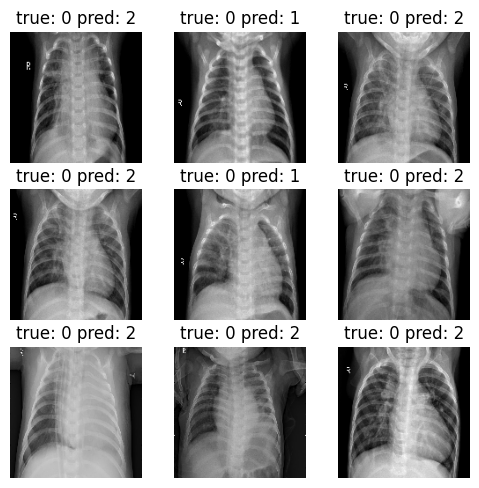

In [ ]:
#use image generation function to display labels, total number to display is last number in function
plot_img_results(sampleimg, sampletrue, samplepred, 0, 9)

# Conclusion

While this model does not produce predictions with jaw dropping accuracy, achieving only 78.5% accuracy on test, it does illustrate a generalized framework for multiclass classification problems using data augmentation and transfer learning that can be implemented with free computing resources. This approach is valuable because it removes the hardware barriers that exist in machine learning, and puts the power to develop and implement models into the hands of more people. This creates the potential for the development of powerful healthcare tools, such as a deep learning framework for predicting pneumonia from chest x-rays.

Thank you for taking the time to review my notebook.
